In [1]:
! pip install kagglehub

  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
Using cached kagglehub-0.3.13-py3-none-any.whl (68 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [kagglehub]/4 [kagglehub]


In [4]:
import kagglehub
import shutil
import os

# Step 1: Download (Kaggle-controlled location)
src_path = kagglehub.dataset_download("mohamedadlyi/aflw2000-3d")

# Step 2: Move / copy to your desired folder
dst_path = "../dataset/aflw2000-3d"
os.makedirs(dst_path, exist_ok=True)

shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print("Dataset copied to:", dst_path)

Dataset copied to: ../dataset/aflw2000-3d


In [25]:
import sys
import os

ROOT_DIR = os.path.abspath("..")
sys.path.append(ROOT_DIR)

In [14]:
import yaml

def load_cfg(cfg_fp):
    with open(cfg_fp, "r") as f:
        return yaml.safe_load(f)


In [28]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import mediapipe as mp

from TDDFA import TDDFA
from FaceBoxes import FaceBoxes
from utils.tddfa_util import _parse_param

# ---------------------------
# Config
# ---------------------------
IMG_DIR = "../dataset/aflw2000-3d/AFLW2000"
OUT_DIR = "data"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------------------
# Init models
# ---------------------------
mp_face = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True
)

tddfa = TDDFA(
    gpu_mode=True,
    arch="mobilenet",
    checkpoint_fp="../weights/mb1_120x120.pth"
)

face_boxes = FaceBoxes()

# ---------------------------
# Storage
# ---------------------------
all_landmarks = []
all_expr = []

# ---------------------------
# Process images
# ---------------------------
for img_name in tqdm(os.listdir(IMG_DIR)):
    if not img_name.lower().endswith((".jpg", ".png")):
        continue

    img_fp = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_fp)
    if img is None:
        continue

    h, w, _ = img.shape
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # MediaPipe landmarks
    results = mp_face.process(img_rgb)
    if not results.multi_face_landmarks:
        continue

    lm = results.multi_face_landmarks[0].landmark
    lm = np.array([[p.x * w, p.y * h, p.z * w] for p in lm]).flatten()
    all_landmarks.append(lm)

    # 3DDFA expression
    boxes = face_boxes(img)
    if len(boxes) == 0:
        all_landmarks.pop()
        continue

    param_lst, roi_box_lst = tddfa(img, [boxes[0]])
    _, _, _, alpha_exp = _parse_param(param_lst[0])
    all_expr.append(alpha_exp)

# ---------------------------
# Save
# ---------------------------
np.save(os.path.join(OUT_DIR, "landmarks.npy"), np.array(all_landmarks))
np.save(os.path.join(OUT_DIR, "expressions.npy"), np.array(all_expr))

print("Dataset created:")
print("Landmarks:", np.array(all_landmarks).shape)
print("Expressions:", np.array(all_expr).shape)


I0000 00:00:1765758724.099654    3867 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765758724.133097    8609 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (AMD Radeon(TM) Graphics)
W0000 00:00:1765758724.142767    8593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765758724.178190    8594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 4001/4001 [01:16<00:00, 52.19it/s]


Dataset created:
Landmarks: (1828, 1434)
Expressions: (1828, 10, 1)


In [ ]:
import mediapipe as mp
mp_face = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
)
def extract_landmarks(image):
    results = mp_face.process(image)
    if not results.multi_face_landmarks:
        return None

    lm = results.multi_face_landmarks[0].landmark
    coords = np.array([[p.x, p.y, p.z] for p in lm])  # (468, 3)
    return coords

libEGL warning: DRI3: Screen seems not DRI3 capable
libEGL warning: DRI3: Screen seems not DRI3 capable
MESA: error: ZINK: failed to choose pdev
libEGL warning: egl: failed to create dri2 screen
Dropped Escape call with ulEscapeCode : 0x03007703
I0000 00:00:1765758189.884104    3867 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765758189.930349    6870 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (AMD Radeon(TM) Graphics)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1765758189.983663    6856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765758190.065916    6855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# -------------------------------
# Config
# -------------------------------
DATA_DIR = "data"
LANDMARKS_FP = os.path.join(DATA_DIR, "landmarks.npy")
EXPRESSIONS_FP = os.path.join(DATA_DIR, "expressions.npy")

BATCH_SIZE = 128
EPOCHS = 50
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)
import torch
torch.set_grad_enabled(True)


# -------------------------------
# Dataset
# -------------------------------
class ExpressionDataset(Dataset):
    def __init__(self, lm_fp, exp_fp):
        self.X = np.load(lm_fp).astype(np.float32)
        self.y = np.load(exp_fp).astype(np.float32).squeeze(-1)

        assert self.X.shape[0] == self.y.shape[0]
        assert self.X.shape[1] == 478 * 3
        assert self.y.shape[1] == 10

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])

# -------------------------------
# Model
# -------------------------------
class ExpressionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(478 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

# -------------------------------
# Training
# -------------------------------
def train():
    dataset = ExpressionDataset(LANDMARKS_FP, EXPRESSIONS_FP)
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    model = ExpressionHead().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    print(f"Training on {DEVICE}, samples: {len(dataset)}")

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0.0

        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for x, y in pbar:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            pred = model(x)
            loss = criterion(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch+1}: avg loss = {avg_loss:.6f}")

        # Save checkpoint
        torch.save(
            model.state_dict(),
            os.path.join(SAVE_DIR, f"expr_head_epoch{epoch+1}.pth")
        )

        

    torch.save(model.state_dict(), os.path.join(SAVE_DIR, "expr_head_final.pth"))
    print("Training complete!")
    return model

# -------------------------------
# Entry
# -------------------------------
if __name__ == "__main__":
    model = train()


Training on cuda, samples: 1828


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 39.89it/s, loss=0.0962]


Epoch 1: avg loss = 0.229907


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 41.50it/s, loss=0.136]


Epoch 2: avg loss = 0.127948


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 44.00it/s, loss=0.102] 


Epoch 3: avg loss = 0.105420


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 42.16it/s, loss=0.0882]


Epoch 4: avg loss = 0.091366


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 41.90it/s, loss=0.121] 


Epoch 5: avg loss = 0.091416


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 42.68it/s, loss=0.0831]


Epoch 6: avg loss = 0.081449


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 42.31it/s, loss=0.0676]


Epoch 7: avg loss = 0.073943


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 45.67it/s, loss=0.0719]


Epoch 8: avg loss = 0.076992


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 50.29it/s, loss=0.0811]


Epoch 9: avg loss = 0.074166


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 47.40it/s, loss=0.0453]


Epoch 10: avg loss = 0.070609


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 51.76it/s, loss=0.0812]


Epoch 11: avg loss = 0.071265


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 48.06it/s, loss=0.0605]


Epoch 12: avg loss = 0.065925


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 44.22it/s, loss=0.0955]


Epoch 13: avg loss = 0.069300


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 38.96it/s, loss=0.0821]


Epoch 14: avg loss = 0.066652


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 37.72it/s, loss=0.0786]


Epoch 15: avg loss = 0.065065


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 46.92it/s, loss=0.0486]


Epoch 16: avg loss = 0.065173


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 46.83it/s, loss=0.0434]


Epoch 17: avg loss = 0.062481


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 44.59it/s, loss=0.0574]


Epoch 18: avg loss = 0.058342


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 45.17it/s, loss=0.0252]


Epoch 19: avg loss = 0.058881


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 39.98it/s, loss=0.126] 


Epoch 20: avg loss = 0.060692


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 38.01it/s, loss=0.05] 


Epoch 21: avg loss = 0.060076


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 39.53it/s, loss=0.0559]


Epoch 22: avg loss = 0.059566


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 38.09it/s, loss=0.0563]


Epoch 23: avg loss = 0.057026


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 40.04it/s, loss=0.0633]


Epoch 24: avg loss = 0.056547


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 38.32it/s, loss=0.0552]


Epoch 25: avg loss = 0.054155


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 48.39it/s, loss=0.077]


Epoch 26: avg loss = 0.058015


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 52.11it/s, loss=0.0703]


Epoch 27: avg loss = 0.057586


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 48.65it/s, loss=0.0556]


Epoch 28: avg loss = 0.056154


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 48.66it/s, loss=0.0694]


Epoch 29: avg loss = 0.054690


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 52.68it/s, loss=0.0554]


Epoch 30: avg loss = 0.056811


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 40.76it/s, loss=0.0484]


Epoch 31: avg loss = 0.055756


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 43.12it/s, loss=0.0544]


Epoch 32: avg loss = 0.053008


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 43.00it/s, loss=0.0421]


Epoch 33: avg loss = 0.049774


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 37.71it/s, loss=0.0855]


Epoch 34: avg loss = 0.052458


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 38.39it/s, loss=0.0498]


Epoch 35: avg loss = 0.052237


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 38.35it/s, loss=0.0734]


Epoch 36: avg loss = 0.053329


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 41.11it/s, loss=0.0657]


Epoch 37: avg loss = 0.051316


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 49.31it/s, loss=0.0551]


Epoch 38: avg loss = 0.050894


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 48.56it/s, loss=0.053] 


Epoch 39: avg loss = 0.050327


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 48.21it/s, loss=0.0536]


Epoch 40: avg loss = 0.051276


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 48.04it/s, loss=0.0601]


Epoch 41: avg loss = 0.049939


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 47.38it/s, loss=0.0579]


Epoch 42: avg loss = 0.050240


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 36.63it/s, loss=0.0602]


Epoch 43: avg loss = 0.049829


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 39.69it/s, loss=0.0554]


Epoch 44: avg loss = 0.047421


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 40.95it/s, loss=0.0508]


Epoch 45: avg loss = 0.049784


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 47.16it/s, loss=0.0626]


Epoch 46: avg loss = 0.051875


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 50.36it/s, loss=0.0354]


Epoch 47: avg loss = 0.047843


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 48.05it/s, loss=0.046]


Epoch 48: avg loss = 0.043268


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 44.92it/s, loss=0.0419]


Epoch 49: avg loss = 0.044161


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 45.94it/s, loss=0.0399]


Epoch 50: avg loss = 0.043520
Training complete!


In [33]:
dummy = torch.randn(1, 1434).cuda()
torch.onnx.export(
    model,
    dummy,
    "expression_head.onnx",
    input_names=["landmarks"],
    output_names=["expression"],
    opset_version=11
)


NameError: name 'model' is not defined

In [34]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [35]:
X = np.load("data/landmarks.npy").astype(np.float32)
y = np.load("data/expressions.npy").astype(np.float32).squeeze(-1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [37]:
class ExpressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])


In [38]:
train_ds = ExpressionDataset(X_train, y_train)
val_ds   = ExpressionDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)


In [39]:
train_losses = []
val_losses = []
model = ExpressionHead().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
for epoch in range(EPOCHS):
    # ---------- TRAIN ----------
    model.train()
    total_train_loss = 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        pred = model(x)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---------- VALIDATION ----------
    model.eval()
    total_val_loss = 0
    preds, gts = [], []
    best_val = 99999999
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)

            loss = criterion(pred, y)
            total_val_loss += loss.item()

            preds.append(pred.cpu().numpy())
            gts.append(y.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val:
        best_val = avg_val_loss
        torch.save(model.state_dict(), "expression_head_best.pth")

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train MSE: {avg_train_loss:.4f} "
          f"Val MSE: {avg_val_loss:.4f}")


Epoch [1/50] Train MSE: 0.2027 Val MSE: 0.2093
Epoch [2/50] Train MSE: 0.1302 Val MSE: 2.6071
Epoch [3/50] Train MSE: 0.1121 Val MSE: 0.3057
Epoch [4/50] Train MSE: 0.1075 Val MSE: 1.5884
Epoch [5/50] Train MSE: 0.1023 Val MSE: 0.2402
Epoch [6/50] Train MSE: 0.0926 Val MSE: 1.1580
Epoch [7/50] Train MSE: 0.0889 Val MSE: 0.1179
Epoch [8/50] Train MSE: 0.0837 Val MSE: 0.2326
Epoch [9/50] Train MSE: 0.0849 Val MSE: 0.7008
Epoch [10/50] Train MSE: 0.0839 Val MSE: 0.3415
Epoch [11/50] Train MSE: 0.0827 Val MSE: 0.4534
Epoch [12/50] Train MSE: 0.0818 Val MSE: 0.4221
Epoch [13/50] Train MSE: 0.0750 Val MSE: 0.6900
Epoch [14/50] Train MSE: 0.0766 Val MSE: 0.1452
Epoch [15/50] Train MSE: 0.0808 Val MSE: 0.2172
Epoch [16/50] Train MSE: 0.0738 Val MSE: 0.5910
Epoch [17/50] Train MSE: 0.0720 Val MSE: 0.3401
Epoch [18/50] Train MSE: 0.0756 Val MSE: 0.1713
Epoch [19/50] Train MSE: 0.0771 Val MSE: 0.2005
Epoch [20/50] Train MSE: 0.0714 Val MSE: 0.1220
Epoch [21/50] Train MSE: 0.0699 Val MSE: 0.2003
E

In [40]:
preds = np.concatenate(preds, axis=0)
gts = np.concatenate(gts, axis=0)

final_mse = mean_squared_error(gts, preds)
final_mae = mean_absolute_error(gts, preds)

print("\nFinal Evaluation Metrics:")
print(f"Validation MSE: {final_mse:.6f}")
print(f"Validation MAE: {final_mae:.6f}")



Final Evaluation Metrics:
Validation MSE: 0.172189
Validation MAE: 0.199612


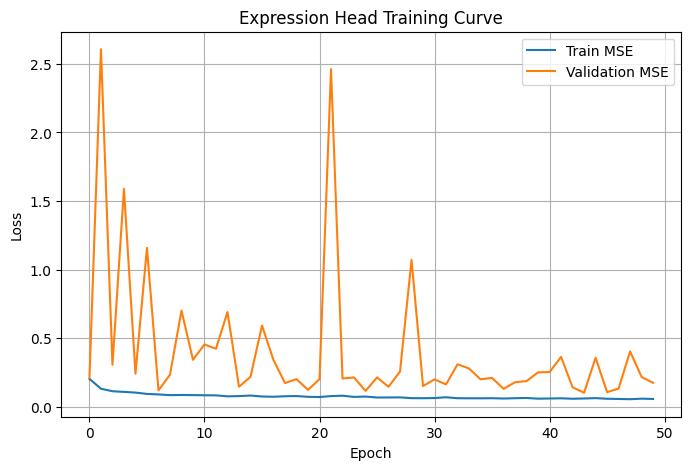

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Expression Head Training Curve")
plt.legend()
plt.grid(True)

plt.savefig("loss_curve.png", dpi=300)
plt.show()
